In [69]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
import glob
import os

### Parameters

In [70]:
good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

task = 'motor'
period = 'post'
participants = 'musicians'
erp_window = 'n05to05'
high_freq = '_30Hz'

#subjects_to_process = ['01', '04', '05', '06', '07','08', '09', '10', '11', '12', '14','15','16','17', '20']
subjects_to_process = ['14', '15', '16','20']


In [71]:
evokeds_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_ERP_data_{erp_window}{high_freq}'
epochs_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_{erp_window}{high_freq}'


In [72]:
#import stored data about times and channels

ch_names_64, ch_names_72 = load_channels()
erp_times = create_erp_times(-0.5, 0.5, 128)

#import data
mne.set_log_level("CRITICAL")
if task == 'listen' or task == 'motor':
    epochs_df = load_epochs_bysubject(subjects_to_process, task, epochs_folder, sub_ave = False);

elif task == 'error':
    epochs_df = load_error_epochs_bysubject(subjects_to_process, 'all', epochs_folder, sub_ave = False);



Processing subject:  14
Processing subject:  15
Processing subject:  16
Processing subject:  20


Wavelet transform parameters

In [6]:
#UTILS

def morwav_trans(timeseries, centerfreq, bandwidth, fs = 128, scale_values = None):
    """ 
    timeseries: a n_timepoints x 1 array
    centerfreq: low centerfreq = small gaussian window, less localized in the freq domain
    bandwidth: the freqs of the wavelet (i.e. how localized in the time domain. Large bandwidth = high temporal precision, low freq res)

    ---
    returns:
    cwtmatr: continuous wavelet transform matrix of size n_freqs x n_timepoints. Imaginary values included.
    freqs: vector of freqs converted from sampling_period and scaling factors
    wavelet: the specified wavelet 
    
    """
    wavelet = f"cmor{centerfreq}-{bandwidth}" #use morelet wavelet

    if scale_values == None:
        scales = np.geomspace(6, 130, 40) #scaling factors. Each channel is the wavelet scaled by some constant. The list of constants is log spaced from 6 to 130
    elif isinstance(scale_values, list):
        scales = np.geomspace(scale_values[0], scale_values[1], scale_values[2])
    sampling_period = 1/fs
    cwtmatr, freqs = pywt.cwt(timeseries, scales, wavelet, sampling_period=sampling_period)

    return cwtmatr, freqs, wavelet

def abs_cwtmatr(cwtmatr):
    """ 
    get the abs value of the matrix
    just use np.abs instead because I don't actually care about getting rid of the last row and colum
    """

    cwtmatr_abs = np.abs(cwtmatr[:-1, :-1])
    return cwtmatr_abs


def plot_scaleogram(cwtmatr, freqs, times, vmax = None):

    """ 
    Plots the scalegram of a wavelet transform given the complex matrix
    times: erp times
    vmax: scaling of colorbar
    """
    #cwtmatr_abs = np.abs(cwtmatr[:-1, :-1])
    cwtmatr_abs =  np.abs(cwtmatr)
    fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed
    pcm = ax.pcolormesh(times, freqs, cwtmatr_abs, vmax = vmax, cmap = 'jet')

    #format axes
    plt.ylabel('Frequencies (Hz)')
    plt.xlabel('Time (s)')
    
    
    #format y axis so that it's readable in log
    ax.set_yscale('log')

    
    ax.set_yticks([ 2, 5, 10, 20, 30])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

    fig.colorbar(pcm, ax=ax)
    

def pad_erp_times(time_vector, num_extend, fs=128):
    """
    Extends a time vector by adding values on both sides, maintaining the step size.

    time_vector (numpy array): Original time vector.
    num_extend (int): Number of values to add on each side.

    Returns:
        numpy array: Extended time vector.
    """
    # Calculate step size
    step_size = 1/fs

    # Extend the time vector on both ends
    start_extend = np.arange(time_vector[0] - step_size * num_extend, time_vector[0], step_size)
    end_extend = np.arange(time_vector[-1] + step_size, time_vector[-1] + step_size * (num_extend + 1), step_size)

    # Combine the arrays
    extended_time_vector = np.concatenate([start_extend, time_vector, end_extend])

    return extended_time_vector


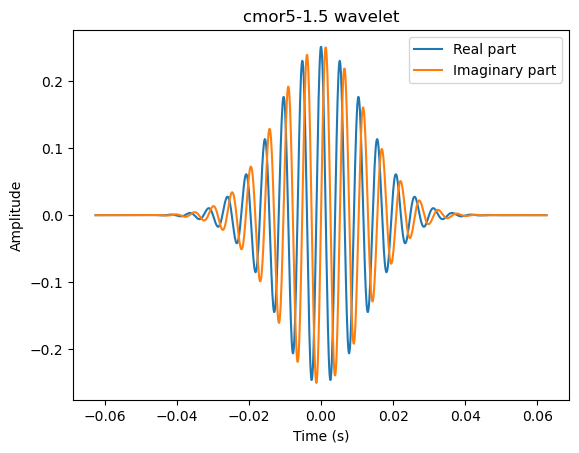

In [7]:
#Visualize the wavelet with 

# Define parameters
sampling_frequency = 128  # example sampling frequency in Hz
centerfreq = 5
bandwidth = 1.5
level = 10
scale_values = [6, 150, 40]

# Generate wavelet
wavelet = pywt.ContinuousWavelet(f'cmor{centerfreq}-{bandwidth}')
psi, x = wavelet.wavefun(level=level)

# Convert x to time (in seconds)
time_per_point = 1 / sampling_frequency
time_axis = x * time_per_point

# Plot real and imaginary parts with the time axis
plt.plot(time_axis, np.real(psi), label='Real part')
plt.plot(time_axis, np.imag(psi), label='Imaginary part')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title(f'{wavelet.name} wavelet')
plt.show()



## Preliminary tests

[32.         29.46492654 27.13068425 24.98136308 23.00231338 21.18004606
 19.50214067 17.95716069 16.53457565 15.22468928 14.01857348 12.90800743
 11.88542158 10.94384606 10.07686313  9.2785635   8.543506    7.86668052
  7.24347386  6.66963829  6.14126257  5.65474533  5.20677049  4.79428469
  4.41447644  4.064757    3.7427427   3.44623871  3.17322408  2.92183795
  2.69036689  2.47723322  2.28098421  2.10028226  1.9338957   1.78069046
  1.6396223   1.50972971  1.39012734  1.28      ]


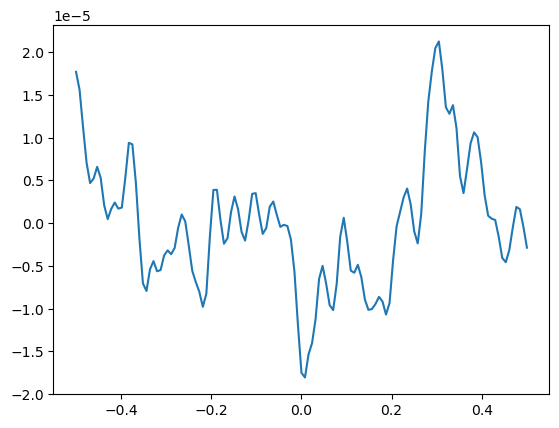

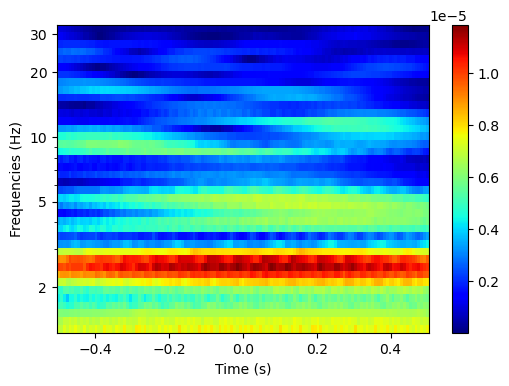

In [8]:
#test wavelet transform
epochs_test = epochs_df.iloc[0]['epochs']
timeseries_test = epochs_test[0,47,:]
plt.plot(erp_times, timeseries_test)
cwtmatr, freqs, wavelet = morwav_trans(timeseries_test, centerfreq=centerfreq, bandwidth=bandwidth, scale_values=scale_values)
print(freqs)

plot_scaleogram(cwtmatr, freqs, erp_times)


### Padding

In [9]:
erp_times_padded = pad_erp_times(erp_times, erp_times.shape[0])

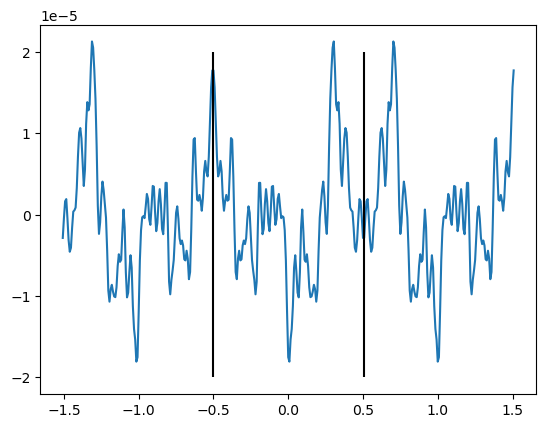

In [10]:
#test wavelet transform but padded

timeseries_test_padded = np.pad(timeseries_test,erp_times.shape[0], mode = 'symmetric')
plt.plot(erp_times_padded, timeseries_test_padded)
plt.vlines(erp_times_padded[erp_times.shape[0]], -2e-5, 2e-5, color = 'black')
plt.vlines(erp_times_padded[2*erp_times.shape[0]], -2e-5, 2e-5, color = 'black')

[32.         29.46492654 27.13068425 24.98136308 23.00231338 21.18004606
 19.50214067 17.95716069 16.53457565 15.22468928 14.01857348 12.90800743
 11.88542158 10.94384606 10.07686313  9.2785635   8.543506    7.86668052
  7.24347386  6.66963829  6.14126257  5.65474533  5.20677049  4.79428469
  4.41447644  4.064757    3.7427427   3.44623871  3.17322408  2.92183795
  2.69036689  2.47723322  2.28098421  2.10028226  1.9338957   1.78069046
  1.6396223   1.50972971  1.39012734  1.28      ]


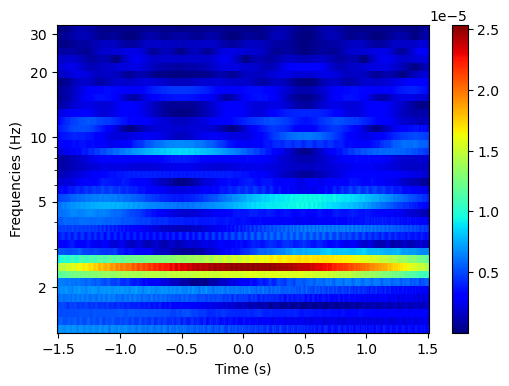

In [11]:
cwtmatr, freqs, wavelet = morwav_trans(timeseries_test_padded, centerfreq=centerfreq, bandwidth=bandwidth, scale_values=scale_values)
print(freqs)

plot_scaleogram(cwtmatr, freqs, erp_times_padded)

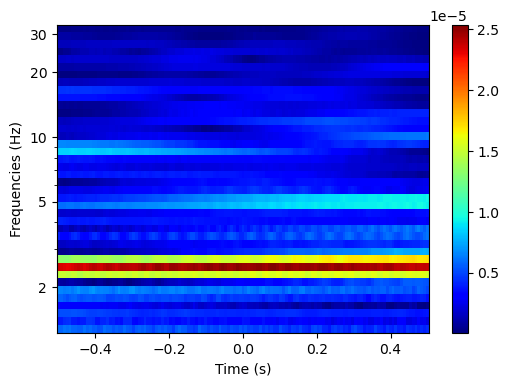

In [12]:
#trim the scalegram
cwtmatr_trimmed = cwtmatr[:, erp_times.shape[0]: 2*erp_times.shape[0]]
plot_scaleogram(cwtmatr_trimmed, freqs, erp_times)

### Power

In [13]:
#sum over wavelet transforms with high freq resolution
cwtmatr_trimmed_abs = np.abs(cwtmatr)
sum_cwtmatr_trimmed = np.sum(cwtmatr_trimmed_abs, axis = 1)
sum_cwtmatr_trimmed.shape

(40,)

Text(0, 0.5, 'power summed over time')

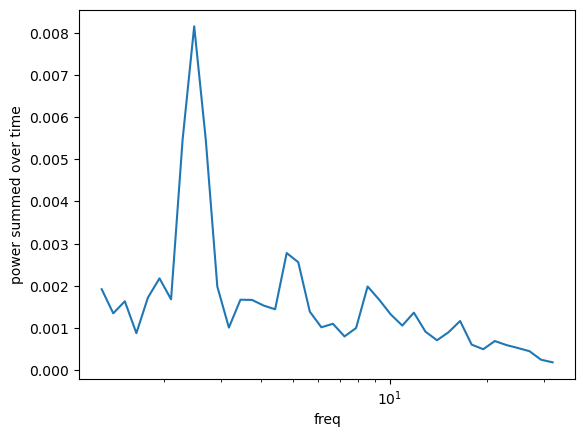

In [14]:
plt.plot(freqs, sum_cwtmatr_trimmed)
plt.xscale('log')
plt.xlabel('freq')
plt.ylabel('power summed over time')

In [15]:
#power over time

In [16]:
cwtmatr.shape

(40, 387)

## Wavelet batches

In [17]:

#subject parameters

subjects_to_process = ['14']
timeseries_test = epochs_df[(epochs_df['subject'] == subjects_to_process[0]) & (epochs_df['period'] == period)]



In [18]:
def wavelet_batch(subjects_to_process, periods, epochs_df):
    """
    subjects_to_process: list of subjects
    periods: list of periods
    epochs_df: dataframe with epoch data already
    ---
    returns:
    wavelet_df: dataframe with info about subjects and spectrogram 
    freqs: array of freqs
    wavelet: mother wavelet used in transform
    """
    
    wavelet_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'spectrogram'])

    for sub in subjects_to_process:
        for period in periods: 
            print('processing subject', sub, period)

            if sub in musicians: 
                    musician = 1
            else: 
                    musician = 0

            
            df_sub = epochs_df[(epochs_df['subject'] == sub) & (epochs_df['period'] == period)]
            epochs_sub = np.squeeze(df_sub['epochs'])
            n_trials = epochs_sub.shape[0]


            #will be made into an array of size n_trials x n_channels x spect_freqs x spect_times
            cwtmatr_sub = []

            #initalize shape of matrix for storing each trial
            test_cwtmatr, _, _ = morwav_trans(epochs_sub[1,1, :], centerfreq=centerfreq, bandwidth=bandwidth, scale_values=scale_values)
            trial_shape = (64, test_cwtmatr.shape[0], test_cwtmatr.shape[1]) #64 channels x cwtmatr dims

            #loop over trials
            for trial in tqdm(range(n_trials)):

                #initialize np array of shape n_channels x spect_freqs x spect_times to store data for one trial
                trial_cwtmatr = np.zeros(trial_shape, dtype=np.complex128)


            #loop over channels
                for ch in range(64):
                    ep_timeseries = epochs_sub[trial, ch, :]
                    #wavelet transform on the channel
                    cwtmatr, freqs, wavelet = morwav_trans(ep_timeseries, centerfreq=centerfreq, bandwidth=bandwidth, scale_values=scale_values)
                
                    trial_cwtmatr[ch] = cwtmatr

                cwtmatr_sub.append(trial_cwtmatr)
            
            
            cwtmatr_sub = np.array(cwtmatr_sub)
            wavelet_df_sub = pd.DataFrame({
                'subject':sub,
                'musician': musician,
                'period': period,
                'spectrogram': [cwtmatr_sub]
            })

            #add sub data to dataframe
            wavelet_df = pd.concat([wavelet_df, wavelet_df_sub])
    return wavelet_df, freqs, wavelet



In [19]:
wavelet_df_test, freqs_test, wavelet_test = wavelet_batch(['14'], ['pre', 'post'], epochs_df) 
#edit to include wavelet parameters!

processing subject 14 pre


100%|██████████| 338/338 [00:55<00:00,  6.09it/s]


processing subject 14 post


100%|██████████| 313/313 [00:51<00:00,  6.05it/s]


To do later: save only the absolute values to csv because csv doesn't like complex numbers
(will also have to update plot_scaleogram)

In [49]:
wavelet_df_test['spect_abs'] = np.abs(wavelet_df_test['spectrogram'])
wavelet_df_abs = wavelet_df_test[['subject', 'musician', 'period', 'spect_abs']]

In [50]:
wavelet_df_abs.to_csv('wavelet_df_abs.csv', index = False)

### Test plots for batch data

Text(0.5, 1.0, 'post')

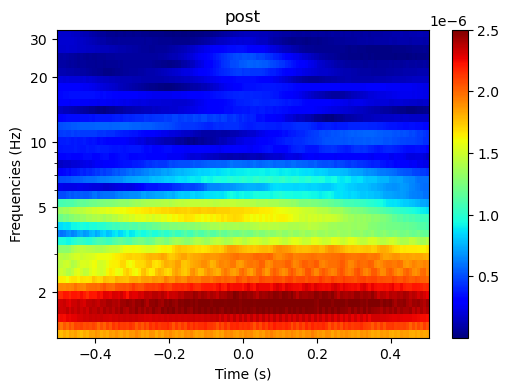

In [30]:
#ave spectrogram

#per = "post" #change this to not use query

wavelet_sub = wavelet_df_test.query(f'period == "post"')
spect_sub = wavelet_sub['spectrogram'][0]

spect_sub_ave = np.mean(spect_sub, axis = 0)
plot_scaleogram(spect_sub_ave[47, :,:], freqs, erp_times, vmax = 2.5e-6)
plt.title('post')

Text(0, 0.5, 'summed power over time')

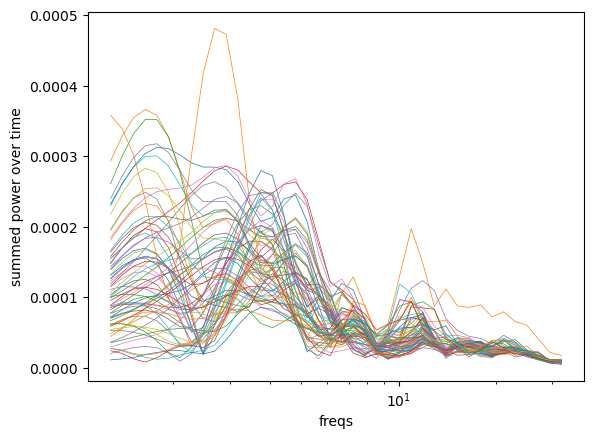

In [31]:
#summed power
spect_sub_ave_abs = np.abs(spect_sub_ave)
power_sum_sub = np.sum(spect_sub_ave_abs, axis = 2)

for ch in range(64):
    plt.plot(freqs, power_sum_sub[ch], linewidth = 0.5)
plt.xscale('log')
plt.xlabel('freqs')
plt.ylabel('summed power over time')

In [38]:
#topography at a frequency

#the load_ep_info() function doesn't work, maybe because erpwavelet has mne 1.8 installed and the other envs have mne 1.5
pos = load_ep_info()



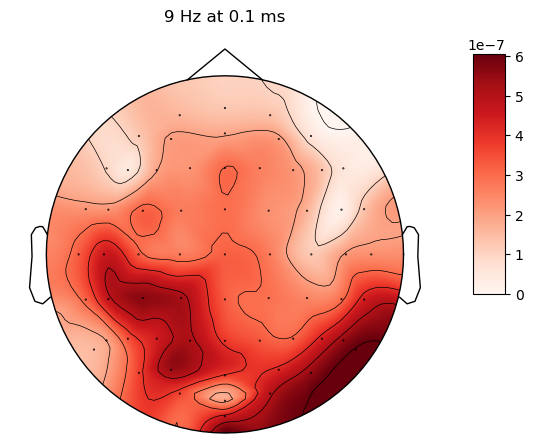

In [60]:
freq_toplot = 9
time_toplot = 0.1
freq_idx = time_index_custom([freq_toplot], freqs)
time_idx = time_index_custom([time_toplot], erp_times)
topo = np.squeeze(spect_sub_ave_abs[:, freq_idx, time_idx])
topo.shape

fig, ax = plt.subplots()
im1, _ = mne.viz.plot_topomap(topo, pos, axes = ax, show = False)
cbar_ax = fig.add_axes([0.9,0.4,0.05,0.5])
clb = fig.colorbar(im1, cax=cbar_ax)
ax.set_title(f'{freq_toplot} Hz at {time_toplot} ms')
plt.show()

## Old stuff part 1

In [ ]:
#save results and take mean
cwtmatr_all = np.concatenate(cwtmatr_all)
cwtmatr_mean = np.mean(cwtmatr_all, axis = 0)

Text(0.5, 1.0, 'motor post')

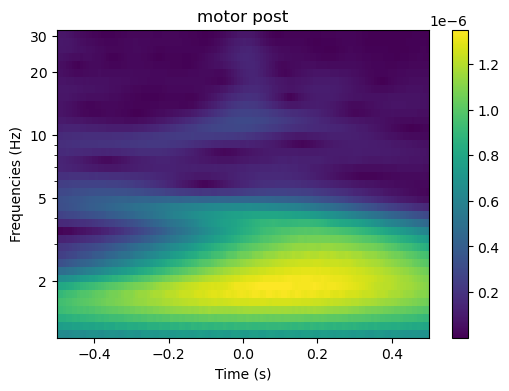

In [ ]:
plot_scaleogram(cwtmatr_mean, freqs, erp_times)
plt.title(f'{task} {period}')

Text(0.5, 1.0, 'individual trial')

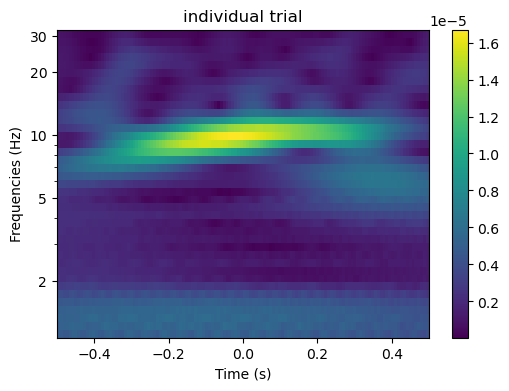

In [ ]:
#inspect individual trials


plot_scaleogram(cwtmatr_all[890], freqs, erp_times)
plt.title('individual trial')

## Old stuff part 2

### Perform continuous wavelet transform (old example)

In [ ]:
"""
wavelet = "cmor1.5-0.6" #complex morlet wavelet: float numbers indicate bandwidth-center freq
vmax = 4e-6

#small bandwidth: poor freq resolution, better time localization
#large bandwidth: good freq resolution, poor time localization

# Use linear scale for scales
widths = np.linspace(1, 70, 70)
#sampling_period = np.diff(erp_times).mean()
sampling_period = erp_times[1] - erp_times[0]
cwtmatr, freqs = pywt.cwt(erp_ave_allch_padded, widths, wavelet, sampling_period=sampling_period)

#absolute value of complex result to extract magnitude info
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# Plot result
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed
pcm = ax.pcolormesh(erp_times_padded, freqs, cwtmatr, vmax = vmax)

# Set axis labels, title, and y-limit
ax.set_yscale('log')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Wavelet transform: {period}-training {task}, {participants}")
ax.set_ylim(0, 50)

y_ticks = np.logspace(np.log10(3), np.log10(35), num=10)  # Adjust 'num' for more or fewer ticks
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())  # Optional: Ensure no scientific notation
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))  # No decimal places

# Add colorbar
fig.colorbar(pcm, ax=ax)

plt.tight_layout()
"""

'\nwavelet = "cmor1.5-0.6" #complex morlet wavelet: float numbers indicate bandwidth-center freq\nvmax = 4e-6\n\n#small bandwidth: poor freq resolution, better time localization\n#large bandwidth: good freq resolution, poor time localization\n\n# Use linear scale for scales\nwidths = np.linspace(1, 70, 70)\n#sampling_period = np.diff(erp_times).mean()\nsampling_period = erp_times[1] - erp_times[0]\ncwtmatr, freqs = pywt.cwt(erp_ave_allch_padded, widths, wavelet, sampling_period=sampling_period)\n\n#absolute value of complex result to extract magnitude info\ncwtmatr = np.abs(cwtmatr[:-1, :-1])\n\n# Plot result\nfig, ax = plt.subplots(figsize=(6, 4))  # Adjust figure size as needed\npcm = ax.pcolormesh(erp_times_padded, freqs, cwtmatr, vmax = vmax)\n\n# Set axis labels, title, and y-limit\nax.set_yscale(\'log\')\nax.set_xlabel("Time (s)")\nax.set_ylabel("Frequency (Hz)")\nax.set_title(f"Wavelet transform: {period}-training {task}, {participants}")\nax.set_ylim(0, 50)\n\ny_ticks = np.logs